# Own dataset for predicting resp rate from ECG
### Decided to make a regression model for creating respiratory signal from ECG

In [66]:
import random
import os
import numpy as np
import pickle
import torch
import torch.nn.functional as F
from tqdm import tqdm
import neurokit2 as nk
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from customLib.preprocess import *
from models.models import LSTM
from customLib.peak_detection import find_mean_avg_r_peak_indices, detect_nk
from customLib.dataset import split_dataset

In [67]:
root_path = "./aidmed_ecgs/with_resp"
aidmed_ecg_sampling_rate = 250
aidmed_resp_sampling_rate = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32

In [68]:
files = [x for x in os.listdir(root_path) if not os.path.isdir(x)]

In [69]:
files = [x for x in os.listdir(root_path) if not os.path.isdir(root_path + "//" + x)]

ecgs = [os.path.join(root_path, x) for x in files[0::3]]
resps =  [os.path.join(root_path, x) for x in files[1::3]]
annotations =  [os.path.join(root_path, x) for x in files[2::3]]

assert len(files) == len(ecgs) + len(resps) + len(annotations)
assert (len(ecgs) + len(resps) + len(annotations)) % 3 == 0

In [70]:
def shift_windows(ecg, resp, annotation):
    """
    Function for shifting one of the signals if they happen to have different time stamps

    Args:
    ecg - a 2D array where the second column (index 1) is timestamps, first column (index 0) is ecg values
    resp - a 2D array where the second column (index 1) is timestamps, first column (index 0) is resp values
    annotation - a 1D array of RESP local maxima indices
    """
    # Accessing the timestamps correctly from index 1
    ecg_first_timestep = ecg[0, 1]
    ecg_last_timestep = ecg[-1, 1]

    resp_first_timestep = resp[0, 1]
    resp_last_timestep = resp[-1, 1]

    try:
        if ecg_first_timestep != resp_first_timestep:
            raise ValueError("start-mismatch")
        if ecg_last_timestep != resp_last_timestep:
            raise ValueError("end-mismatch")
    except ValueError as e:
        if str(e) == "start-mismatch":
            print("Start mismatch detected.")
            if ecg_first_timestep < resp_first_timestep:
                # Find index where ECG timestamps are >= the first RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_first_timestep)[0][0]
                ecg = ecg[mismatch_idx:]  # Remove earlier timestamps in ECG
            else:
                # Find index where RESP timestamps are >= the first ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_first_timestep)[0][0]
                resp = resp[mismatch_idx:]  # Remove earlier timestamps in RESP
                annotation = annotation - mismatch_idx  # Shift annotation indices
                annotation = annotation[annotation > 0]  # Keep only valid positive indices
        elif str(e) == "end-mismatch":
            print("End mismatch detected.")
            if ecg_last_timestep < resp_last_timestep:
                # Find index where RESP timestamps are >= the last ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_last_timestep)[0][0]
                resp = resp[:mismatch_idx]  # Remove later timestamps in RESP
                annotation = annotation[annotation < mismatch_idx]  # Adjust annotation
            else:
                # Find index where ECG timestamps are >= the last RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_last_timestep)[0][0]
                ecg = ecg[:mismatch_idx]  # Remove later timestamps in ECG
        else:
            raise Exception("An unknown data timestamp mismatch occurred.")
    finally:
        # Ensure resp and ecg are 1D after adjusting
        if len(ecg.shape) > 1:
            ecg = ecg[:, 0]  # Assuming first column has RESP values
        if len(resp.shape) > 1:
            resp = resp[:, 0]  # Assuming first column has ECG values

        #print("ECG shape:", ecg_values.shape, " Time:", ecg_values.shape[0] / aidmed_ecg_sampling_rate)
        #print("RESP shape:", resp_values.shape, " Time:", resp_values.shape[0] / aidmed_resp_sampling_rate)

    return ecg, resp, annotation


In [71]:
def plot_ecg_resp(ecg, resp, annotation=None):
    fig, axs = plt.subplots(nrows=2)

    t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(ecg.shape[0])]
    t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(resp.shape[0])]

    ax = axs[0]
    ax.plot(t_ecg, ecg)
    ax.grid()

    ax = axs[1]
    ax.plot(t_resp, resp)
    if annotation:
        ax.plot(annotation * 1/aidmed_resp_sampling_rate, resp[annotation], 'rx')
    ax.grid()

    fig.show()

In [72]:
def pad_signals(window_in_seconds, longest_sequence_length):
    ecg_window_length = window_in_seconds * aidmed_ecg_sampling_rate
    resp_window_length = window_in_seconds * aidmed_resp_sampling_rate

    ecg_target_window_length = longest_sequence_length * aidmed_ecg_sampling_rate
    resp_target_window_length = longest_sequence_length * aidmed_resp_sampling_rate

    x, y = np.empty((0, ecg_target_window_length)), np.empty((0, resp_target_window_length, 2))

    for i, (ecg, resp, annotation) in enumerate(zip(ecgs, resps, annotations)):
        ecg = np.load(ecg)
        resp = np.load(resp)
        with open(annotation, "rb") as f:
            resp_peak_indices = pickle.load(f)

        annotation = np.zeros((resp.shape[0]))
        annotation[resp_peak_indices] = 1

        ecg, resp, annotation = shift_windows(ecg, resp, annotation)
        ecg = myConv1D(signal=ecg, kernel_length=5, padding="same")

        ecg_windows = split_signal(ecg, start=0, window_in_seconds=window_in_seconds, fs=aidmed_ecg_sampling_rate, overlap_factor=0.85, normalize=(True, (-1,1)), denoise=False)
        resp_windows = split_signal(resp, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=0.85, normalize=(True, (-1,1)), denoise=False)      # jensen-shannon normalize to (0,1) -> probability dist
        annotation_windows = split_signal(annotation, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=0.85, normalize=False, denoise=False)

        for i in range(len(resp_windows)):
            clean_resp = nk.rsp.rsp_clean(resp_windows[i], sampling_rate=50)
            resp_windows[i] = myConv1D(clean_resp, kernel_length=100, padding="same")

        # KLDivLoss and jensen - shannon
        # for i in range(len(resp_windows)):
        #     resp_windows[i] = np.exp(resp_windows[i])/sum(np.exp(resp_windows[i]))
                                       
        if len(ecg_windows) > 0:
            if ecg_window_length != ecg_target_window_length:
                padding_begining = np.random.randint(low=0, high=ecg_target_window_length - ecg_window_length, dtype=int)
                padding_end = ecg_target_window_length - ecg_window_length - padding_begining
                ecg_windows = np.pad(array=np.array(ecg_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="mean")

            if resp_window_length != resp_target_window_length:
                padding_begining = int(padding_begining * aidmed_resp_sampling_rate / aidmed_ecg_sampling_rate)
                padding_end = resp_target_window_length - resp_window_length - padding_begining
                resp_windows = np.pad(array=np.array(resp_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="edge")
                annotation_windows = np.pad(array=np.array(annotation_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="constant", constant_values=(0))
            
            resp_and_annotation_windows = np.stack((resp_windows, annotation_windows), axis=-1)
            x = np.concatenate((x, ecg_windows), axis=0)
            y = np.concatenate((y, np.array(resp_and_annotation_windows)), axis=0)
            
    return x, y


In [73]:
#x, y = pad_signals(window_in_seconds=30, longest_sequence_length=30)
# x, y = pad_signals(window_in_seconds=45, longest_sequence_length=45)
x, y = pad_signals(window_in_seconds=60, longest_sequence_length=60)

#x = np.concatenate((x_30, x_45, x_60), axis=0)
#y = np.concatenate((y_30, y_45, y_60), axis=0)

Start mismatch detected.
End mismatch detected.
Start mismatch detected.
End mismatch detected.
End mismatch detected.
End mismatch detected.
Start mismatch detected.
End mismatch detected.
Start mismatch detected.


In [74]:
# Prediction using LSTM for R-peaks detection
lstm_prediction = np.empty((0, x.shape[1]))
num_batches = int(np.ceil(x.shape[0] / batch_size))
model = LSTM(input_dim=1, hidden_size=32, loss_pos_weight=torch.Tensor([17]).to(device))
model.load_state_dict(torch.load("./checkpoints/lstm/raw_ecgs/lstm_epoch_10_acc_99.88_f1_0.98.pt"))

model.eval()
for batch_idx in range(num_batches):
   start_idx = batch_idx * batch_size
   end_idx = min((batch_idx + 1) * batch_size, x.shape[0])

   x_batch = x[start_idx:end_idx]
   x_batch = np.expand_dims(x_batch, axis=2)

   x_tensor = torch.Tensor(x_batch).to(device)

   prediction = model(x_tensor)
   prediction = prediction.detach().cpu().numpy()
   r_peaks_batch = (prediction >= 0.5).astype(int)
   r_peaks_batch = r_peaks_batch.reshape((r_peaks_batch.shape[0], r_peaks_batch.shape[1]))
   r_peaks_batch = [find_mean_avg_r_peak_indices(x) for x in r_peaks_batch]

   lstm_prediction = np.concatenate((lstm_prediction, np.array(r_peaks_batch)), axis=0)


# Prediction using neurokit
r_peaks_prediction = np.empty((0, x.shape[1]))
RPA = []

for ecg in x:
   ecg_peaks_indices = detect_nk(ecg_slice=ecg, fs=aidmed_ecg_sampling_rate)
   ecg_peaks = np.zeros_like(ecg)
   ecg_peaks[ecg_peaks_indices] = 1
   ecg_peaks = np.expand_dims(ecg_peaks, 0)
   r_peaks_prediction = np.concatenate((r_peaks_prediction, ecg_peaks), axis=0)

   RPA.append(ecg[ecg_peaks_indices])


Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_9688\3382541529.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

In [75]:
sample = -200
t_interpolate = [x for x in range((x.shape[1]))]


# LSTM prediction
single_peaks_pred = lstm_prediction[sample]
r_peaks_lstm = np.where(single_peaks_pred == 1)[0]
RRs_lstm = np.diff(r_peaks_lstm) * 1/aidmed_ecg_sampling_rate * 1000

# Extend the R_wave_indices and RRs for interpolation - LSTM
r_peaks_lstm_extended = np.concatenate(([0], r_peaks_lstm.tolist(), [len(single_peaks_pred) - 1]), axis=0)
RRs_interpolation_lstm = np.concatenate(([np.mean(RRs_lstm)], RRs_lstm, [RRs_lstm[-1], np.mean(RRs_lstm)]))

# interpolation - LSTM
first_order_hold_lstm = interp1d(r_peaks_lstm_extended, RRs_interpolation_lstm, kind="linear")
interpolation_lstm = first_order_hold_lstm(t_interpolate)


# nuerokit prediction
r_peaks_nk = detect_nk(ecg_slice=x[sample], fs=250)
RRs_nk = np.diff(r_peaks_nk) * 1/aidmed_ecg_sampling_rate * 1000

# Extend the R_wave_indices and RRs for interpolation - Neurokit
r_peaks_nk_extended = np.concatenate(([0], r_peaks_nk.tolist(), [len(single_peaks_pred) - 1]), axis=0)
RRs_interpolation_nk = np.concatenate(([np.mean(RRs_nk)], RRs_nk, [RRs_nk[-1], np.mean(RRs_nk)]))

# interpolation - Neurokit
first_order_hold_nk = interp1d(r_peaks_nk_extended, RRs_interpolation_nk, kind="linear")
interpolation_nk = first_order_hold_nk(t_interpolate)

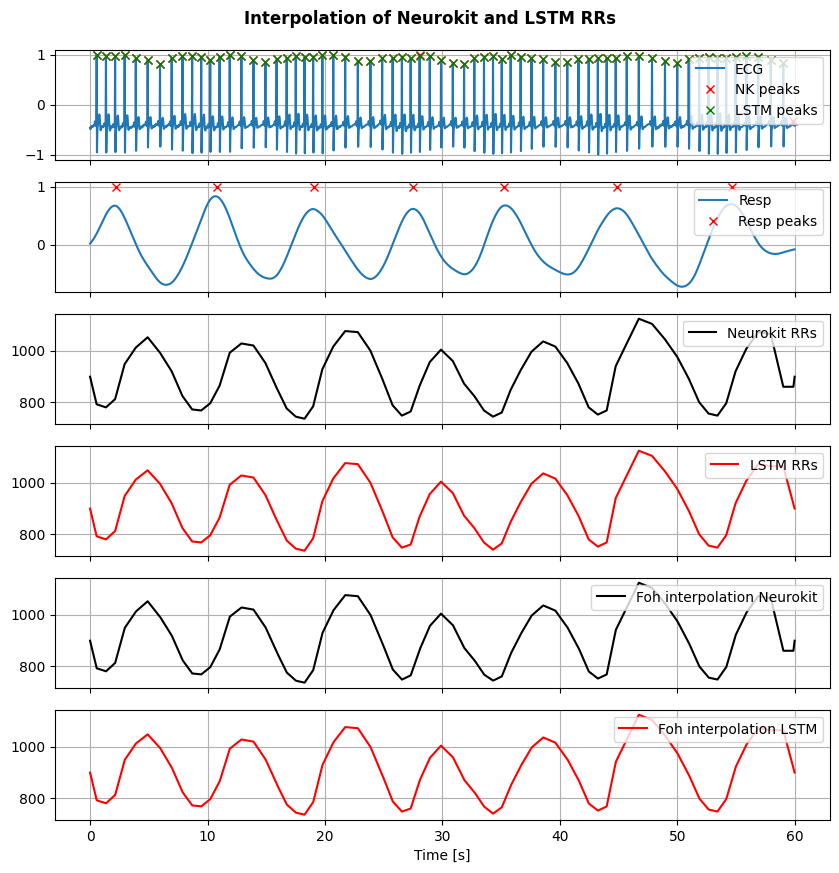

In [76]:
t = [x * 1/ aidmed_ecg_sampling_rate for x in range(len(x[sample]))]
t_resp = [x * 1/ aidmed_resp_sampling_rate for x in range(len(y[sample]))]

resp_peks = np.where(y[sample][:,1] == 1)[0]

fig, axs = plt.subplots(nrows=6, sharex=True)

ax = axs[0]
ax.grid()
ax.plot(t, x[sample])
ax.plot(r_peaks_nk * 1/ aidmed_ecg_sampling_rate, x[sample][r_peaks_nk], 'rx')
ax.plot(r_peaks_lstm * 1/ aidmed_ecg_sampling_rate, x[sample][r_peaks_lstm], 'gx')
ax.legend(["ECG", "NK peaks", "LSTM peaks"], loc='upper right')

ax = axs[1]
ax.plot(t_resp, y[sample][:,0])
ax.plot(resp_peks * 1/ aidmed_resp_sampling_rate, y[sample][resp_peks,1], 'rx')
ax.grid()
ax.legend(["Resp", "Resp peaks"], loc='upper right')

ax = axs[2]
ax.plot(r_peaks_nk_extended * 1/ aidmed_ecg_sampling_rate, RRs_interpolation_nk, 'k-')
ax.grid()
ax.legend(["Neurokit RRs"], loc='upper right')

ax = axs[3]
ax.plot(r_peaks_lstm_extended * 1/ aidmed_ecg_sampling_rate, RRs_interpolation_lstm, 'r-')
ax.grid()
ax.legend(["LSTM RRs"], loc='upper right')

ax = axs[4]
ax.plot([ x * 1 / aidmed_ecg_sampling_rate for x in range(len(interpolation_nk))], interpolation_nk, 'k-')
ax.grid()
ax.legend(["Foh interpolation Neurokit"], loc='upper right')

ax = axs[5]
ax.plot([ x * 1 / aidmed_ecg_sampling_rate for x in range(len(interpolation_lstm))], interpolation_lstm, 'r-')
ax.grid()
ax.legend(["Foh interpolation LSTM"], loc='upper right')

plt.xlabel("Time [s]")
fig.suptitle("Interpolation of Neurokit and LSTM RRs", x=0.5,y=0.92, fontweight="semibold")
fig.set_size_inches(10,10)

In [12]:
# zoh_form_wave = []

# for prediction in r_peaks_prediction:
#     R_wave_indices_interpolation = np.where(prediction == 1)[0]
#     RRs_interpolation = np.diff(R_wave_indices_interpolation) * 1/aidmed_ecg_sampling_rate * 1000
#     RRs_interpolation = norm_min_max(signal=RRs_interpolation, lower=-1, upper=1)

#     if 0 not in R_wave_indices_interpolation:
#         R_wave_indices_interpolation = np.concatenate(([0], R_wave_indices_interpolation), axis=0)
#         RRs_interpolation = np.concatenate(([np.mean(RRs_interpolation)], RRs_interpolation), axis=0)

#     if len(prediction) not in R_wave_indices:
#         R_wave_indices_interpolation = np.concatenate((R_wave_indices_interpolation, [len(prediction)]), axis=0)
#         RRs_interpolation = np.concatenate((RRs_interpolation, [RRs_interpolation[-1], np.mean(RRs_interpolation)]), axis=0)
    
#     zoh = interp1d(R_wave_indices_interpolation, RRs_interpolation, kind="zero")
#     t_interpolate = [x for x in range(len(prediction))]
#     interpolation = zoh(t_interpolate)

#     zoh_form_wave.append(interpolation)


# x_stacked = np.stack((x, np.array(zoh_form_wave)), axis=2)

### Append new channel/s to ECG - RR intervals interpolation, RPA interpolation, R Peaks indices as a square wave

In [78]:
foh_waveform_interpolation = []
rpa_waveform_interpolation = []

for prediction, RPA_waveform in zip(r_peaks_prediction, RPA):
    R_wave_indices_interpolation = np.where(prediction == 1)[0]
    RRs_interpolation = np.diff(R_wave_indices_interpolation) * 1/aidmed_ecg_sampling_rate * 1000
    RRs_interpolation = norm_min_max(signal=RRs_interpolation, lower=0, upper=1)

    if 0 not in R_wave_indices_interpolation:
        R_wave_indices_interpolation = np.concatenate(([0], R_wave_indices_interpolation), axis=0)
        RRs_interpolation = np.concatenate(([np.mean(RRs_interpolation)], RRs_interpolation), axis=0)
        RPA_waveform = np.concatenate(([RPA_waveform[0]], RPA_waveform), axis=0)

    if (len(prediction) - 1) not in r_peaks_nk:
        R_wave_indices_interpolation = np.concatenate((R_wave_indices_interpolation, [len(prediction) - 1]), axis=0)
        RRs_interpolation = np.concatenate((RRs_interpolation, [RRs_interpolation[-1], np.mean(RRs_interpolation)]), axis=0)
        RPA_waveform = np.concatenate((RPA_waveform, [RPA_waveform[-1]]), axis=0)
    
    foh_rrs = interp1d(R_wave_indices_interpolation, RRs_interpolation, kind="linear")
    foh_rpa = interp1d(R_wave_indices_interpolation, RPA_waveform, kind="linear")

    t_interpolate = [x for x in range(len(prediction))]

    interpolation_rrs = foh_rrs(t_interpolate)
    interpolation_rpa = foh_rpa(t_interpolate)

    foh_waveform_interpolation.append(interpolation_rrs)
    rpa_waveform_interpolation.append(interpolation_rpa)


x_stacked = np.stack((x, np.array(foh_waveform_interpolation), np.array(rpa_waveform_interpolation)), axis=2)
# x = np.stack((x, np.array(rpa_waveform_interpolation)), axis=2)
#x = np.stack((x, np.array(r_peaks_prediction)), axis=2)

In [14]:
# sample = 20

# test = torch.Tensor(x_stacked[sample][:,0].reshape(1,x.shape[1],1)).to(device)
# r_peaks = model(test)
# r_peaks = r_peaks.detach().cpu().numpy()
# r_peaks = np.where(r_peaks > 0.5, 1, 0)
# r_peaks = find_mean_avg_r_peak_indices(r_peaks)
# r_peaks = np.where(r_peaks == 1)[0]

# fig, axs = plt.subplots(nrows=2)

# t = [x * 1/aidmed_ecg_sampling_rate for x in range(x_stacked.shape[1])]

# ax = axs[0]
# ax.grid()
# ax.plot(t, x_stacked[sample][:, 0])
# ax.plot(r_peaks * 1/ aidmed_ecg_sampling_rate, x_stacked[-1][r_peaks, 0], 'rx')

# ax = axs[1]
# ax.plot(t, x_stacked[sample][:, 1], 'r')
# ax.grid()
# ax.legend(["FOH interpolation"])

In [79]:
from torch import nn
import torch.nn.functional as F

def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (F.kl_div(F.log_softmax(p, dim=-1), m, reduction='batchmean') +
                  F.kl_div(F.log_softmax(q, dim=-1), m, reduction='batchmean'))

class NCC(nn.Module):
    def __init__(self):
        super(NCC, self).__init__()

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes the normalized cross-correlation coefficient for batched input signals.
        The input signals x and y must be of shape [batch_size, seq_length].
        Returns a mean value of the cross-correlation coefficients.
        """
        assert x.shape == y.shape, "X and Y must be of the same shape"

        x_mean = torch.mean(x, dim=1, keepdim=True)
        y_mean = torch.mean(y, dim=1, keepdim=True)

        x_prime = x - x_mean
        y_prime = y - y_mean

        covariance = torch.sum(x_prime * y_prime, dim=1)
        std_x = torch.sqrt(torch.sum(x_prime ** 2, dim=1))
        std_y = torch.sqrt(torch.sum(y_prime ** 2, dim=1))

        denominator = std_x * std_y
        r_xy = torch.where(denominator != 0, covariance / denominator, torch.zeros_like(covariance))

        return torch.mean(r_xy)

class ConvBackbone(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBackbone, self).__init__()
    
        self.conv_backbone = nn.ModuleList([
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=5, stride=5),  # Reduce sequence length by 5x
        ])
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        for layer in self.conv_backbone:
            x = layer(x)
        x = x.permute(0, 2, 1)
        return x

class RespToECG(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, input_seq_length=7500, output_seq_length=1500):
        super(RespToECG, self).__init__()

        self.lstm_1 = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True, dropout=0.3)
        self.lstm_2 = torch.nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dense_1 = torch.nn.Linear(in_features=2*hidden_size, out_features=hidden_size)
        self.dense_2 = torch.nn.Linear(in_features=hidden_size, out_features=1)
        self.dense_3 = torch.nn.Linear(in_features=input_seq_length, out_features=output_seq_length)

        self.layer_norm_1 = nn.LayerNorm(2*hidden_size)
        self.layer_norm_2 = nn.LayerNorm(2*hidden_size)

        self.dropout = torch.nn.Dropout1d(p=0.3)

        self.kernel_size=20
        self.smoothening_kernel = torch.FloatTensor([[[1/self.kernel_size for _ in range(self.kernel_size)]]]).to(device)
        self.to(device)

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x = self.layer_norm_1(x)

        x, _ = self.lstm_2(x)
        x = self.layer_norm_2(x)

        x = self.dense_1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.dense_2(x)
        x = x.squeeze(-1)
        
        x = self.dense_3(x)
        # x = F.log_softmax(x, dim=-1) # KLDivLoss
        # x = F.softmax(x, dim=-1) # jensen-shannon


        # x = x.unsqueeze(2)
        # x = x.permute((0,2,1))
        # x = F.conv1d(x, weight=self.smoothening_kernel, padding="same")
        # x = x.permute((0,2,1))
        # x = x.squeeze()
        return x

In [80]:
class DeviceDataset(Dataset):
  def __init__(self, data, labels):
    super(DeviceDataset, self).__init__()
    self.data = data
    self.labels = labels
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32).to(self.device)
    label = torch.tensor(self.labels[idx], dtype=torch.float32).to(self.device)
    return sample, label

In [81]:
x_train, y_train, x_test, y_test = split_dataset(x=x_stacked, y=y, is_validation_set=False, shuffle=True)

#x_train = x_train[:20]
#y_train = y_train[:20]

#x_train = np.expand_dims(x_train, 2)
#x_test = np.expand_dims(x_test, 2)

train_dataset = DeviceDataset(data=x_train, labels=y_train)
test_dataset = DeviceDataset(data=x_test, labels=y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Total X: 903


c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\customLib\dataset.py:34: UserWarning: Path is not specified. The dataset is not being saved.
  warnings.warn("Path is not specified. The dataset is not being saved.")


In [82]:
def plot_result(title, inputs, targets, outputs):
    rand_idx = random.randint(0, inputs.shape[0] - 1)
    input = inputs[rand_idx].detach().cpu().numpy()
    ecg = input[:, 0]
    rrs = input[:, 1]
    rpa = input[:, 2]

    target = targets[rand_idx][:,0]
    target = target.detach().cpu().numpy()

    resp_regression = outputs[rand_idx]
    resp_regression = resp_regression.detach().cpu().numpy()
    resp_regression = myConv1D(resp_regression, kernel_length=50, padding="same")

    rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=1000)
    ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=aidmed_ecg_sampling_rate, desired_length=len(ecg))
    # edr = nk.ecg_rsp(ecg_rate, sampling_rate=aidmed_ecg_sampling_rate)
    # edr = resample_signal(signal=edr, num_samples=len(target))
    # edr = norm_min_max(edr, lower=0, upper=1)

    fig, axs = plt.subplots(nrows=2)

    t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(len(ecg))]
    t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(len(target))]
    
    ax = axs[0]
    ax.plot(t_ecg, ecg.flatten())
    ax.plot(t_ecg, rrs.flatten())
    ax.plot(t_ecg, rpa.flatten())
    ax.grid()
    ax.legend(["ECG", "RRIs", "RPA"])

    ax = axs[1]
    ax.plot(t_resp, target.flatten())
    ax.plot(t_resp, resp_regression.flatten(), 'r-')
    # ax.plot(t_resp, edr.flatten(), 'b-')
    ax.legend(["Target", "Regression", "EDR"])
    ax.grid()

    fig.suptitle(title)
    fig.set_size_inches(8,8)
    plt.show()

def validate(epoch, model, val_loader, alfa=0.5):
    model.eval()  # Set the model to evaluation mode
    criterion_1 = nn.L1Loss()
    # NCC(), nn.KLDivLoss(reduction="batchmean") (not really usefull here, when comparing a period of 60 sec breath)
    criterion_2 = nn.CosineEmbeddingLoss()

    epoch_val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, (inputs, targets) in enumerate(val_loader):
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss_1 = criterion_1(outputs, targets[:,:,0])
            # loss_2 = criterion_2(outputs, targets[:,:,0])

            similarity_tensor = torch.tensor([1 for _ in range(targets.shape[0])]).to(device)
            loss_2 = criterion_2(outputs, targets[:,:,0], similarity_tensor)

            loss = (1-alfa) * loss_1 + alfa * (1 - loss_2)

            # loss = (1-alfa) * loss_1 + alfa * jensen_shannon_divergence(outputs, targets[:,:,0])

            epoch_val_loss += loss.item()

            if i % 5 == 0:
                plot_result(f"Epoch {epoch + 1} - validation", inputs, targets, outputs)

    # Return the average validation loss
    return epoch_val_loss / len(val_loader)

def train(model, train_loader, val_loader, epochs=20, learning_rate=0.001, alfa=0.2):
    criterion_1 = nn.L1Loss()
    # NCC(), nn.KLDivLoss(reduction="batchmean") (not really usefull here, when comparing a period of 60 sec breath)
    criterion_2 = nn.CosineEmbeddingLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss_1 = criterion_1(outputs, targets[:,:,0])
            # loss_2 = criterion_2(outputs, targets[:,:,0])

            similarity_tensor = torch.tensor([1 for _ in range(targets.shape[0])]).to(device)
            loss_2 = criterion_2(outputs, targets[:,:,0], similarity_tensor)

            # loss = (1-alfa) * loss_1 + alfa * (1 - loss_2) # NCE
            loss = (1 - alfa) * loss_1 + alfa * loss_2 # cosine

            # loss = (1-alfa) * loss_1 + alfa * jensen_shannon_divergence(outputs, targets[:,:,0])


            loss.backward()
            optimizer.step()

            if batch_idx == len(train_loader) - 1:
                plot_result(f"Epoch {epoch + 1} - train", inputs, targets, outputs)
            

            epoch_train_loss += loss.item()

        scheduler.step()
        
        avg_val_loss = validate(epoch, model, val_loader, alfa=alfa)
        print(f'Epoch [{epoch+1}/{epochs}], LR: {scheduler.get_last_lr()}, Average Train Loss: {epoch_train_loss / len(train_loader)}, Average Validation Loss: {avg_val_loss}')
    
    return model

In [83]:
model = RespToECG(input_size=x_train.shape[2], input_seq_length=x_train.shape[1], output_seq_length=y_train.shape[1])

e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


 96%|█████████▌| 22/23 [01:22<00:03,  3.73s/it]

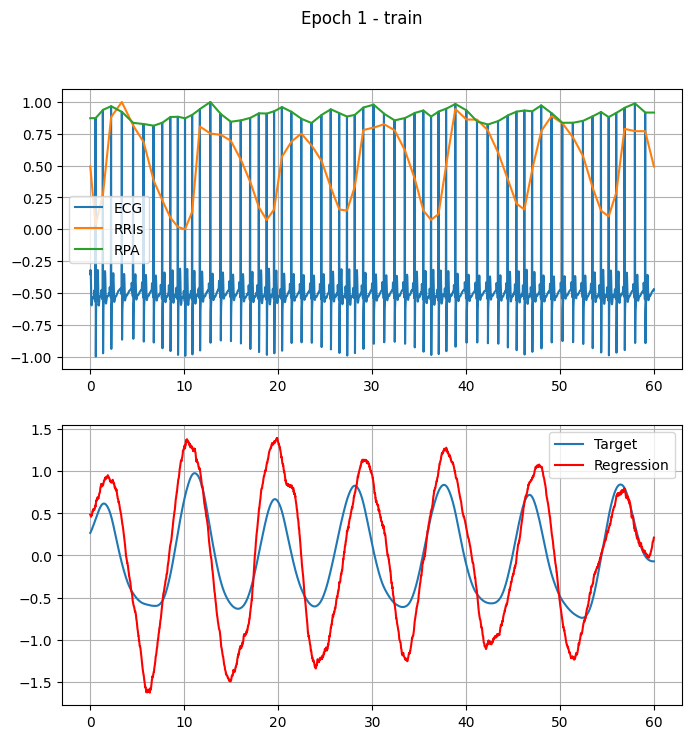

100%|██████████| 23/23 [01:24<00:00,  3.66s/it]


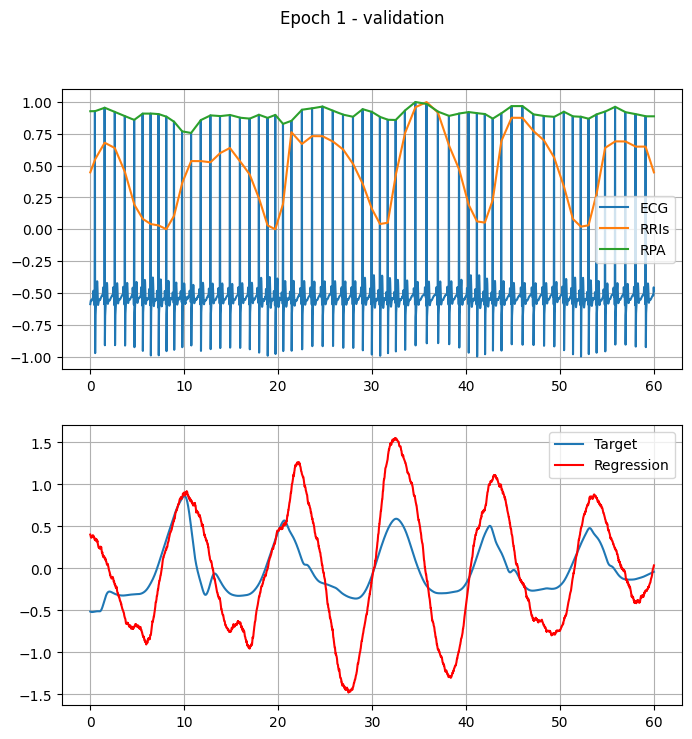

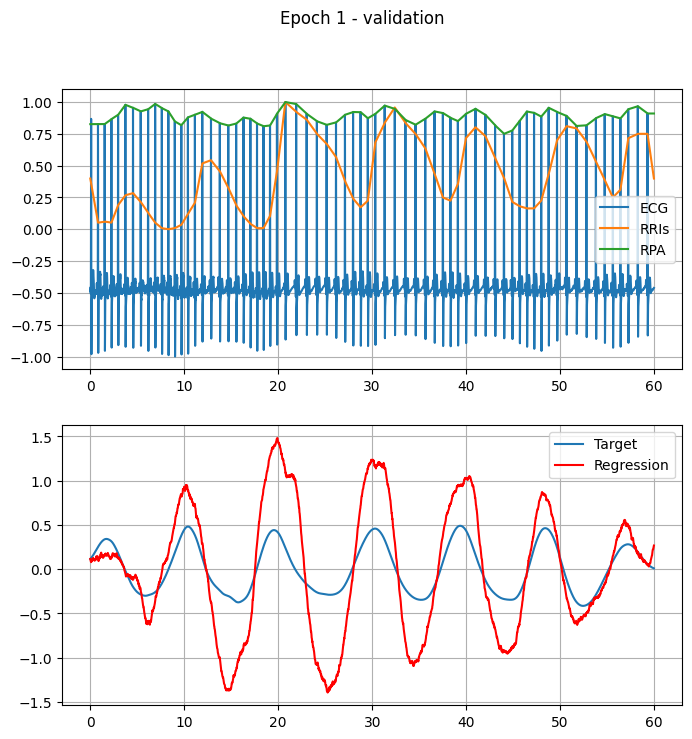

Epoch [1/30], LR: [0.001], Average Train Loss: 0.7281865412774293, Average Validation Loss: 0.5618236462275187


 96%|█████████▌| 22/23 [01:19<00:03,  3.59s/it]

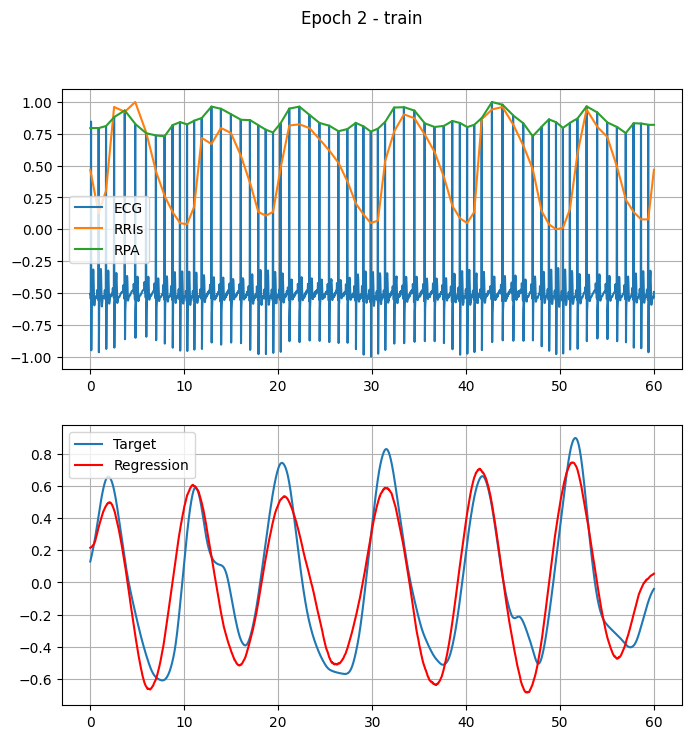

100%|██████████| 23/23 [01:21<00:00,  3.52s/it]


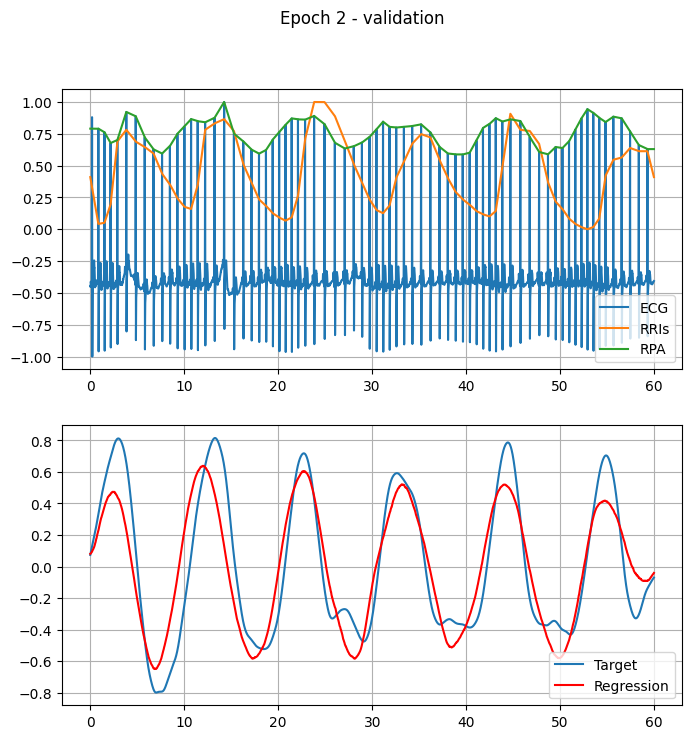

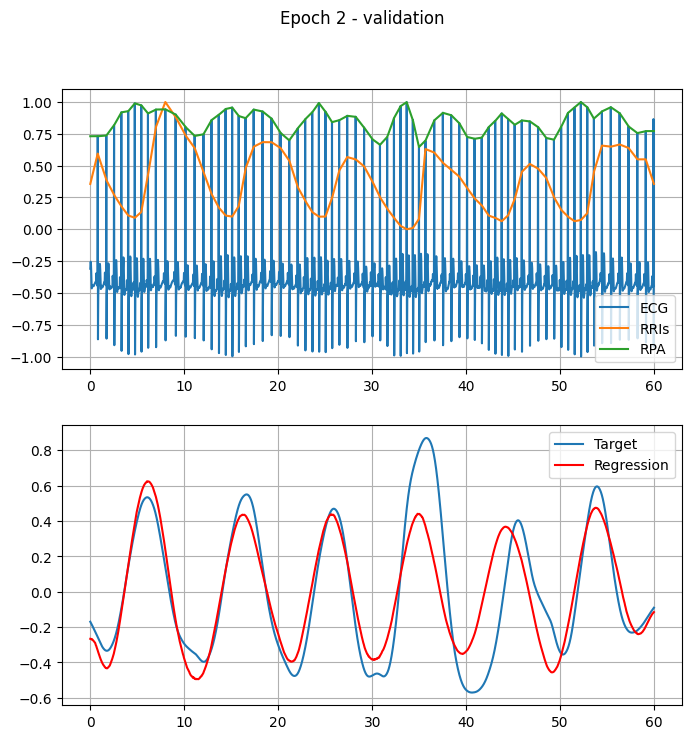

Epoch [2/30], LR: [0.001], Average Train Loss: 0.21592337411382925, Average Validation Loss: 0.5046116511027018


 96%|█████████▌| 22/23 [01:21<00:03,  3.88s/it]

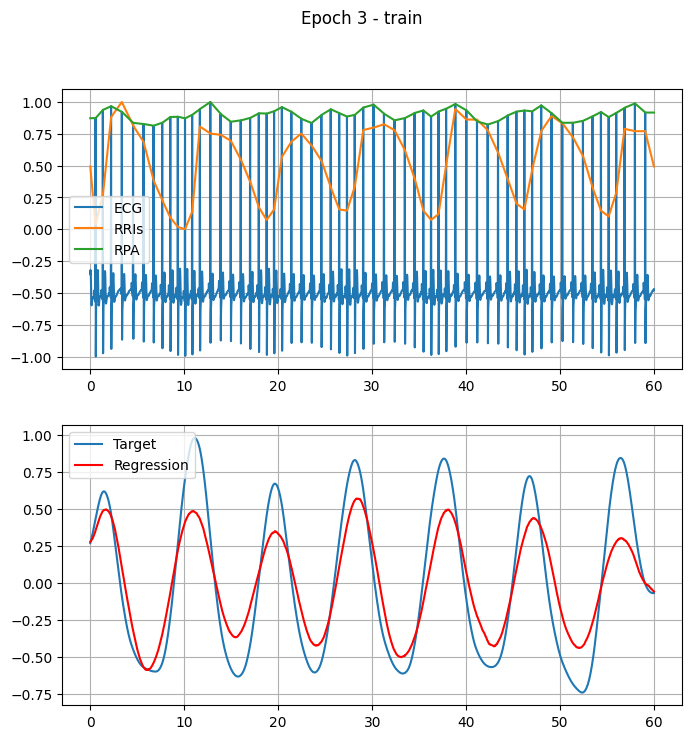

100%|██████████| 23/23 [01:23<00:00,  3.63s/it]


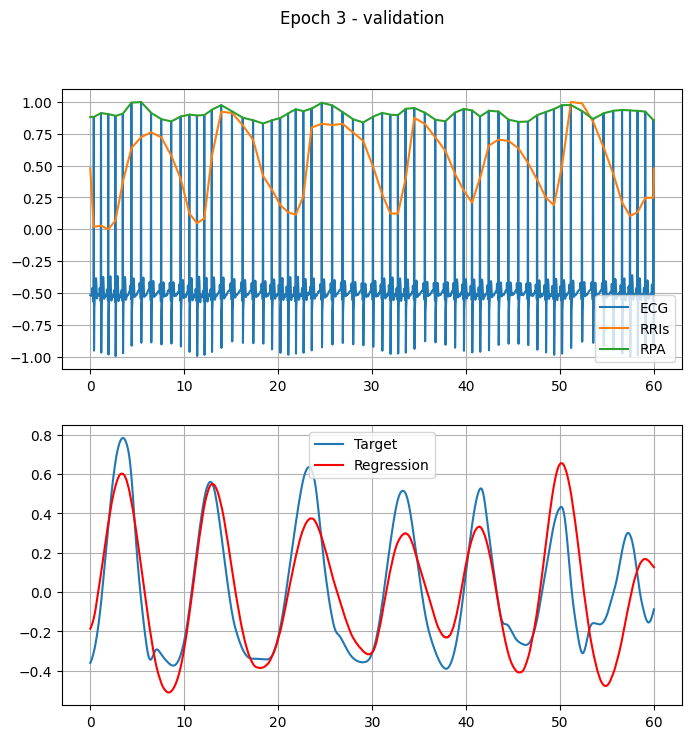

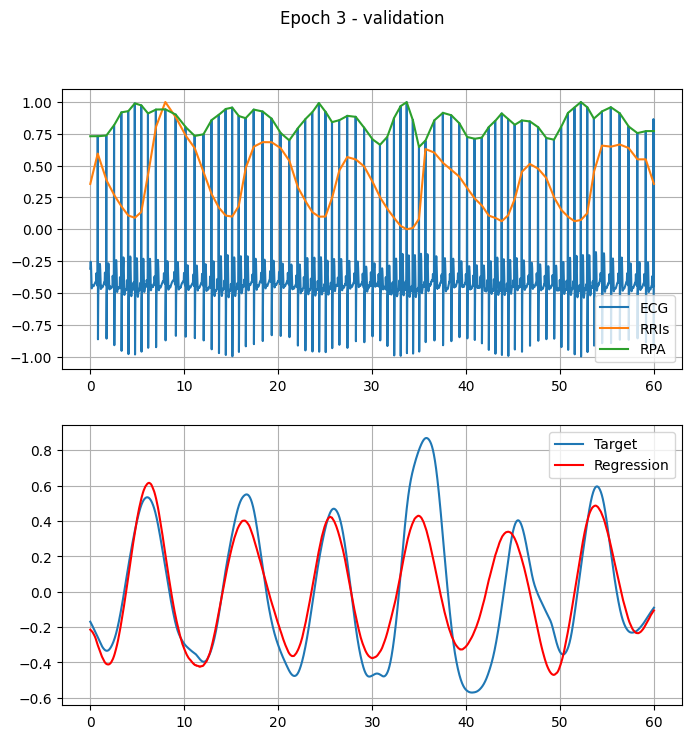

Epoch [3/30], LR: [0.001], Average Train Loss: 0.1626940376084784, Average Validation Loss: 0.5079293350378672


 96%|█████████▌| 22/23 [01:25<00:03,  3.76s/it]

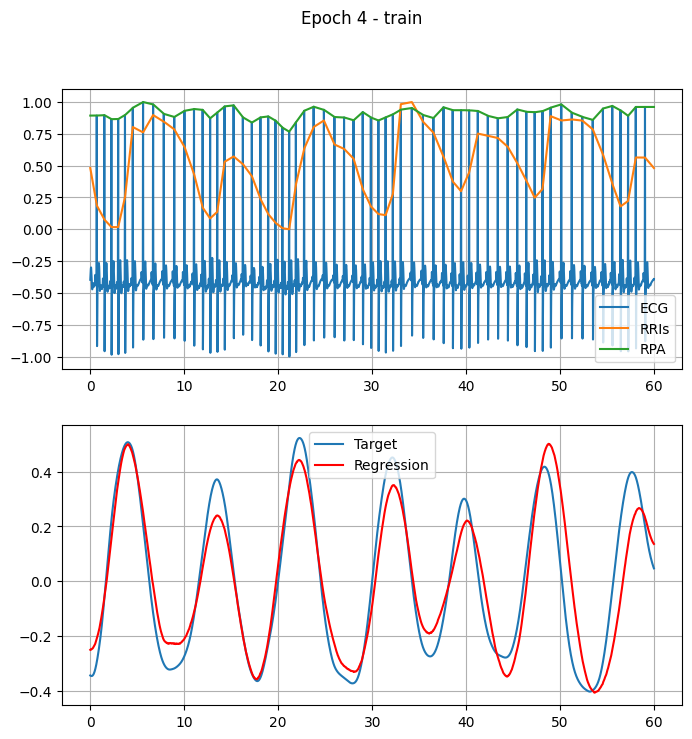

100%|██████████| 23/23 [01:27<00:00,  3.79s/it]


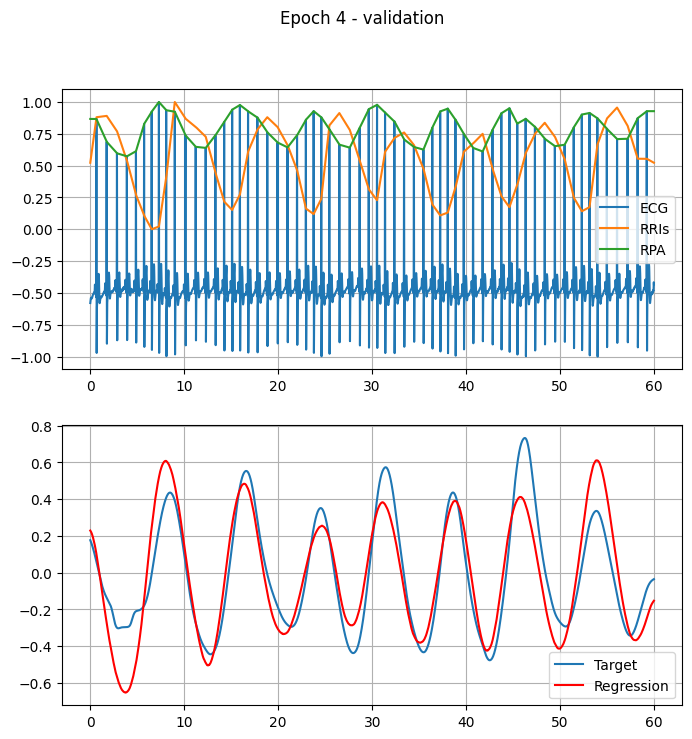

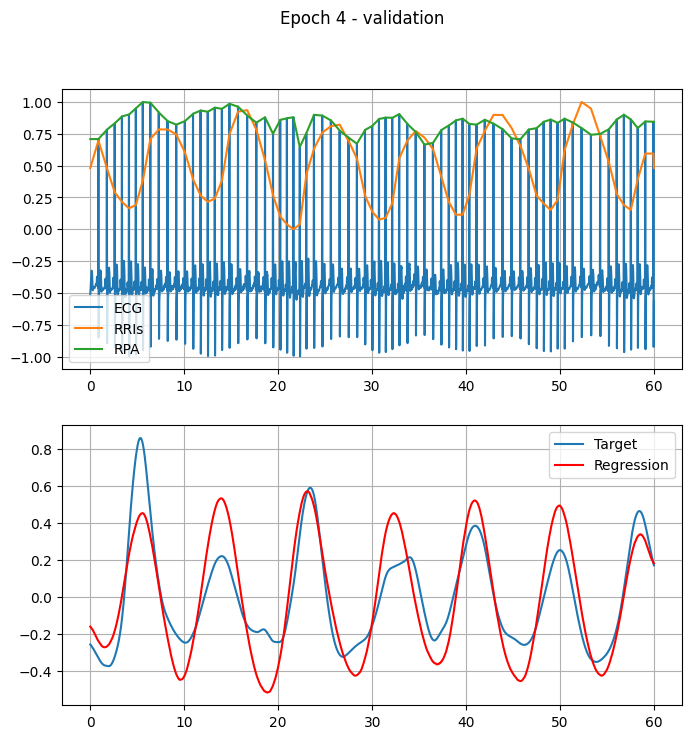

Epoch [4/30], LR: [0.001], Average Train Loss: 0.1539001192735589, Average Validation Loss: 0.5087569355964661


 96%|█████████▌| 22/23 [01:22<00:03,  3.76s/it]

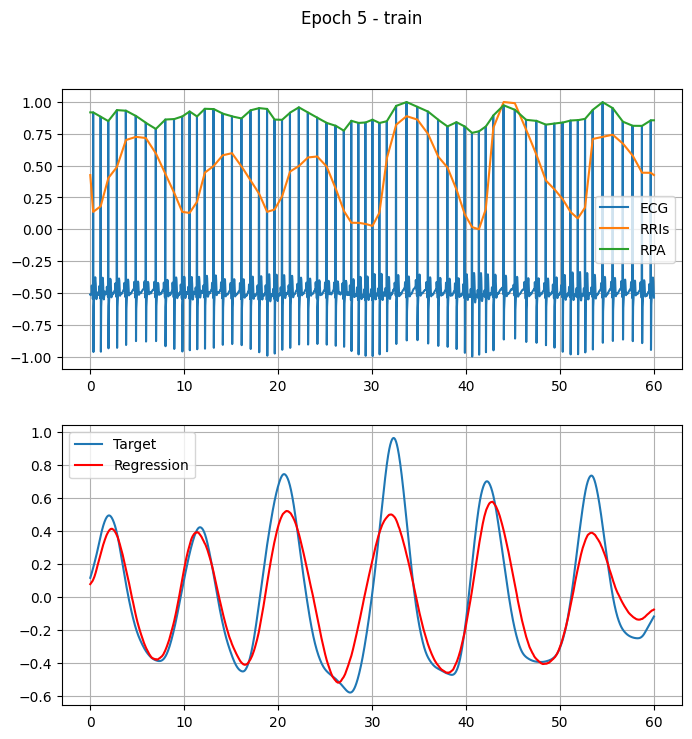

100%|██████████| 23/23 [01:24<00:00,  3.68s/it]


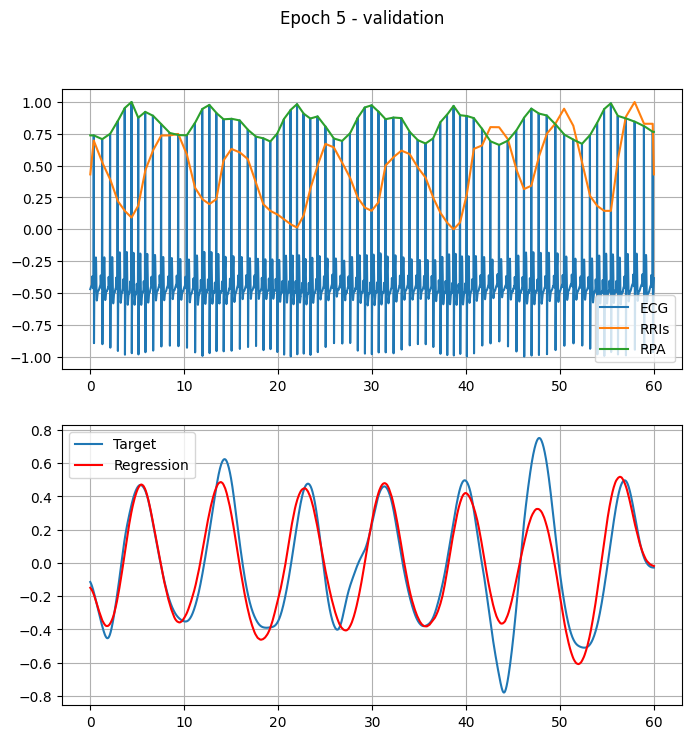

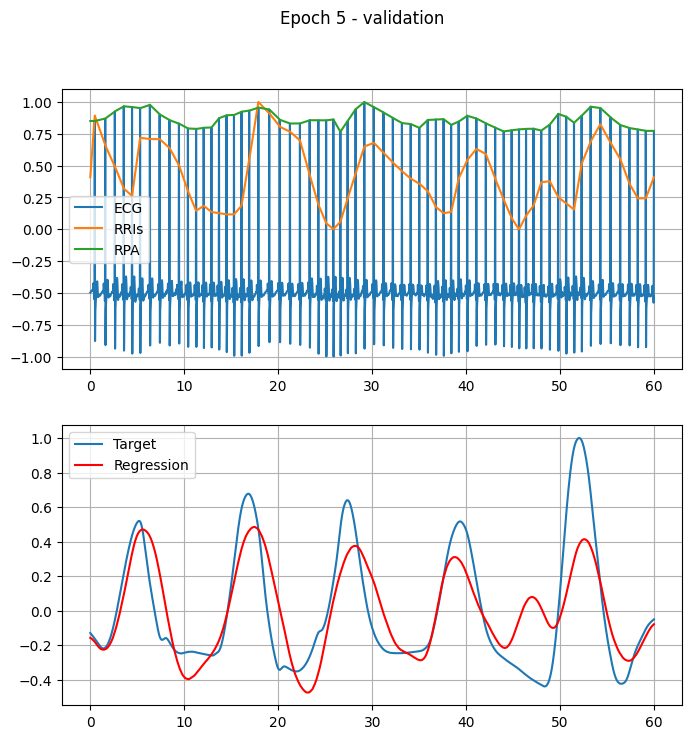

Epoch [5/30], LR: [0.001], Average Train Loss: 0.14989767741897833, Average Validation Loss: 0.5082365026076635


 96%|█████████▌| 22/23 [01:23<00:03,  3.81s/it]

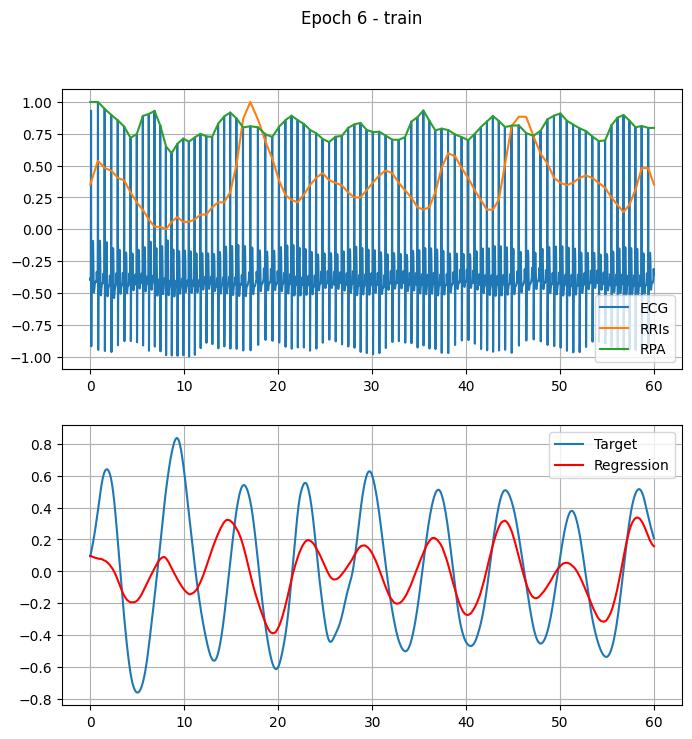

100%|██████████| 23/23 [01:25<00:00,  3.70s/it]


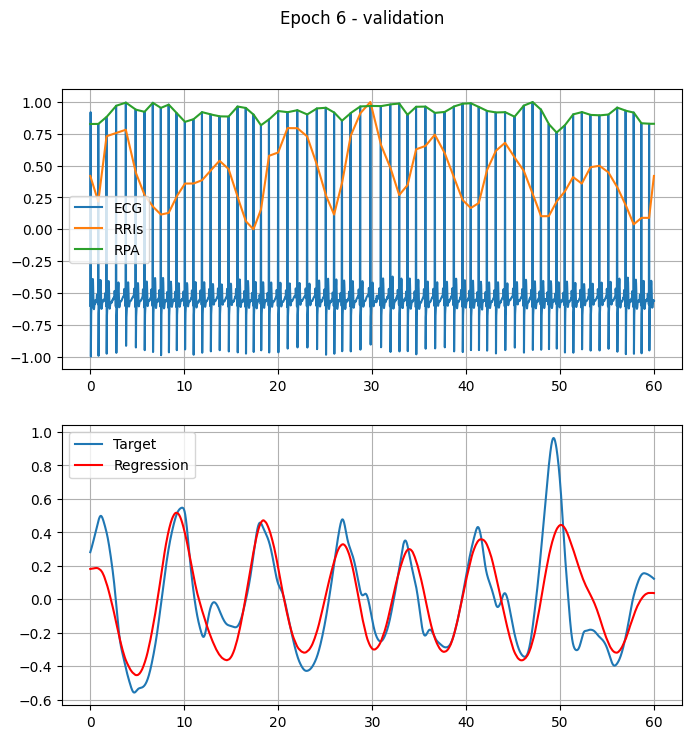

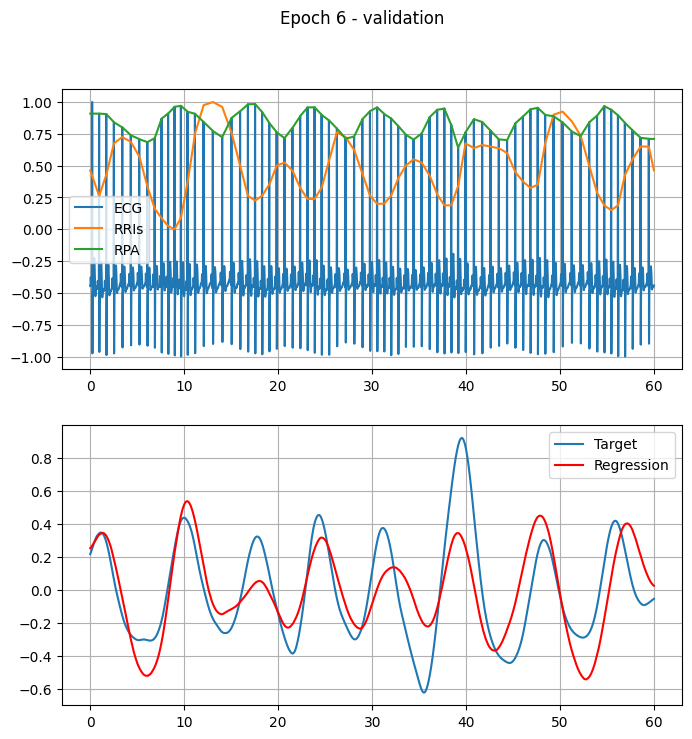

Epoch [6/30], LR: [0.001], Average Train Loss: 0.14714378377665643, Average Validation Loss: 0.5092118283112844


 96%|█████████▌| 22/23 [01:23<00:03,  3.87s/it]

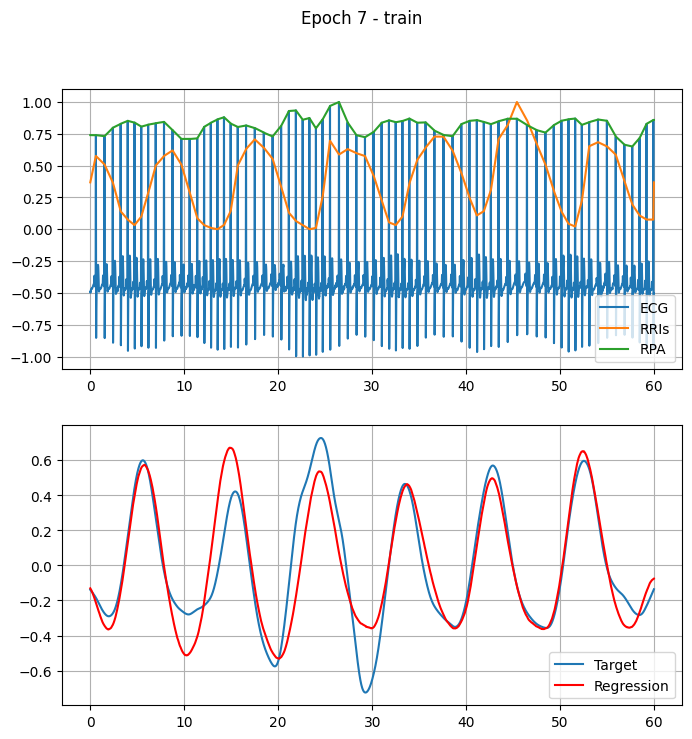

100%|██████████| 23/23 [01:25<00:00,  3.72s/it]


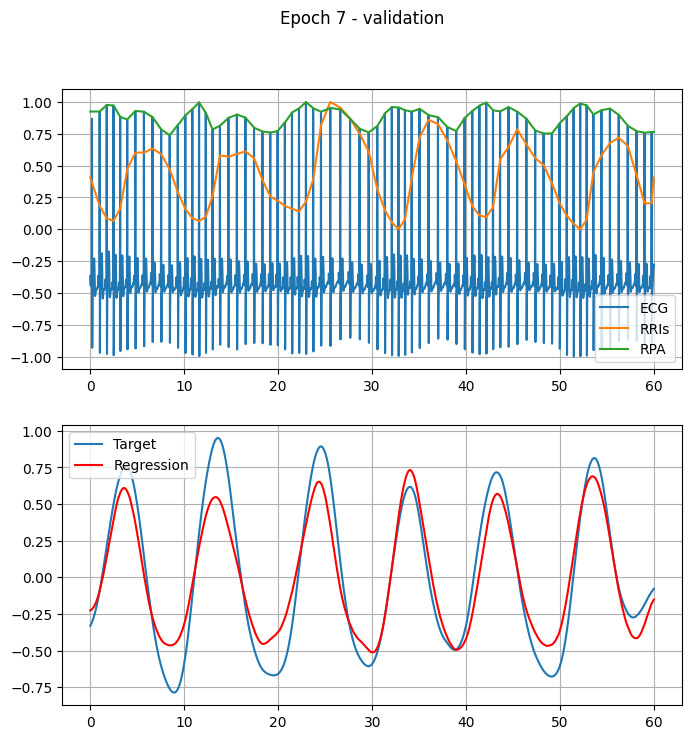

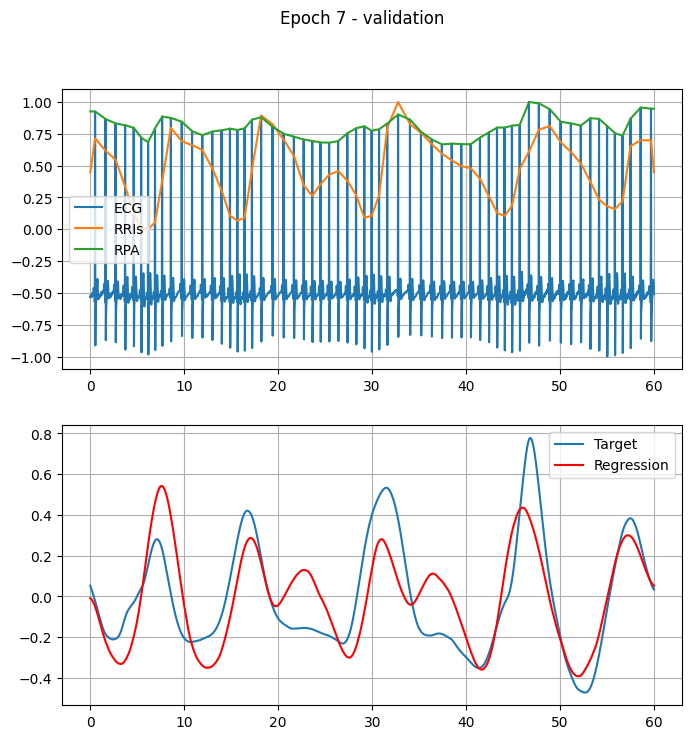

Epoch [7/30], LR: [0.001], Average Train Loss: 0.1459591770949571, Average Validation Loss: 0.5083494981129965


 96%|█████████▌| 22/23 [01:23<00:03,  3.76s/it]

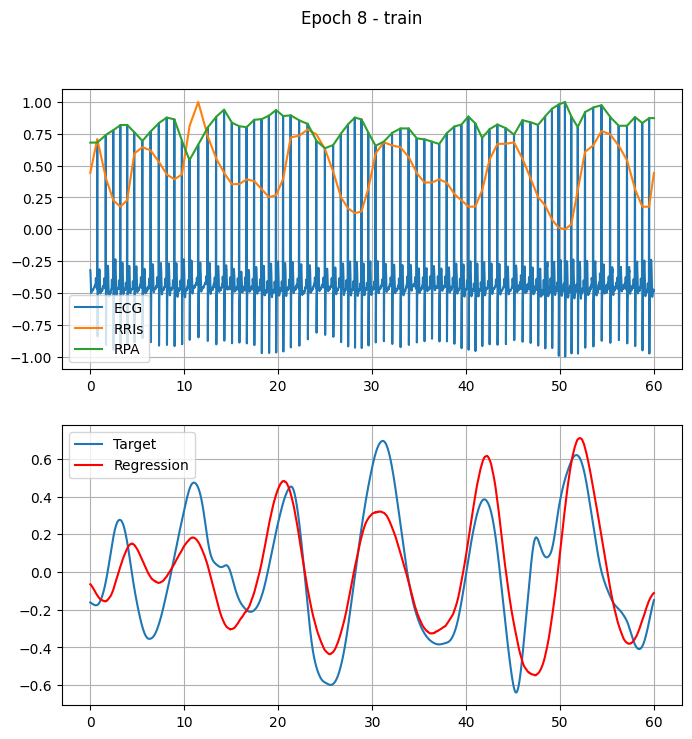

100%|██████████| 23/23 [01:25<00:00,  3.72s/it]


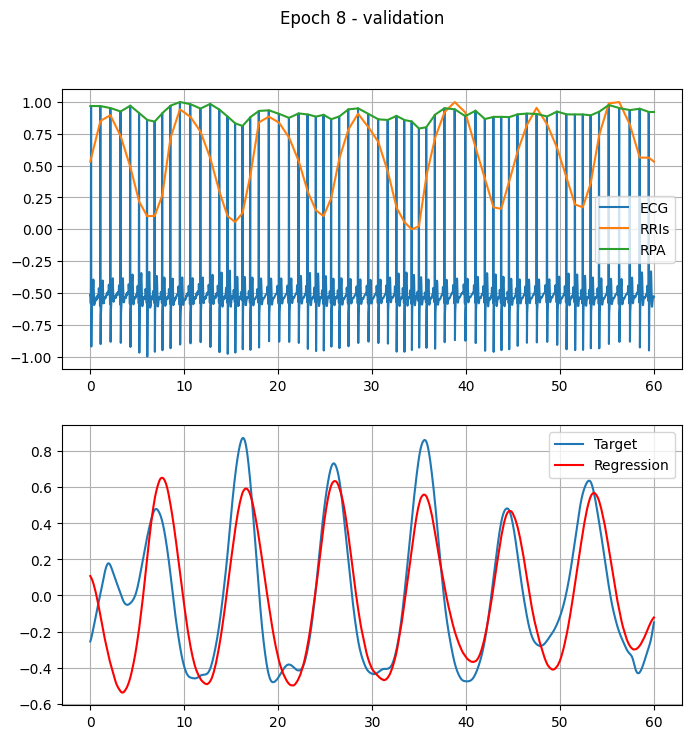

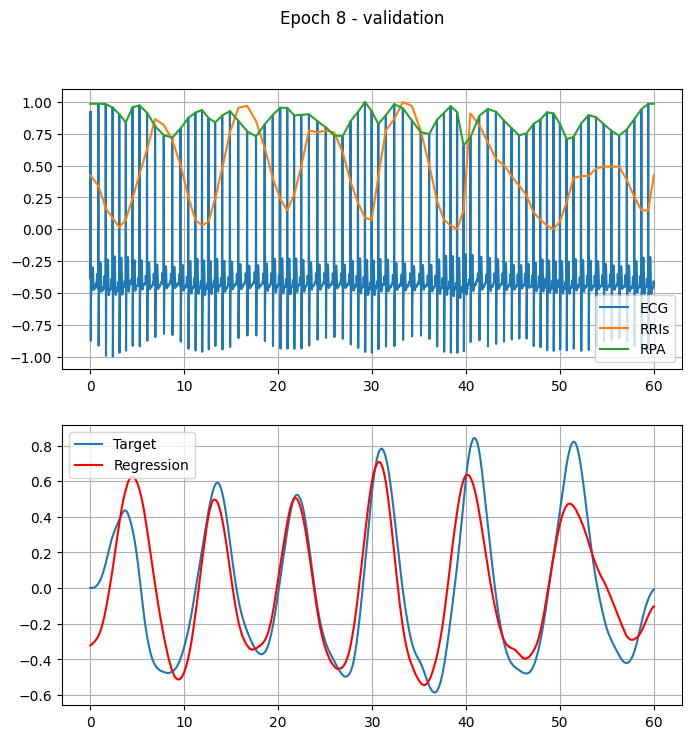

Epoch [8/30], LR: [0.001], Average Train Loss: 0.14193782145562378, Average Validation Loss: 0.5086050927639008


 96%|█████████▌| 22/23 [01:27<00:03,  3.78s/it]

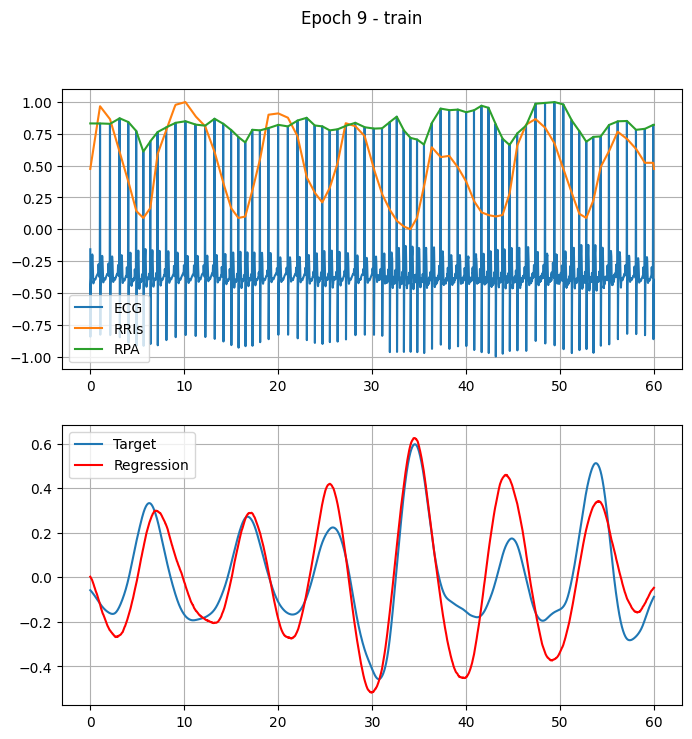

100%|██████████| 23/23 [01:29<00:00,  3.88s/it]


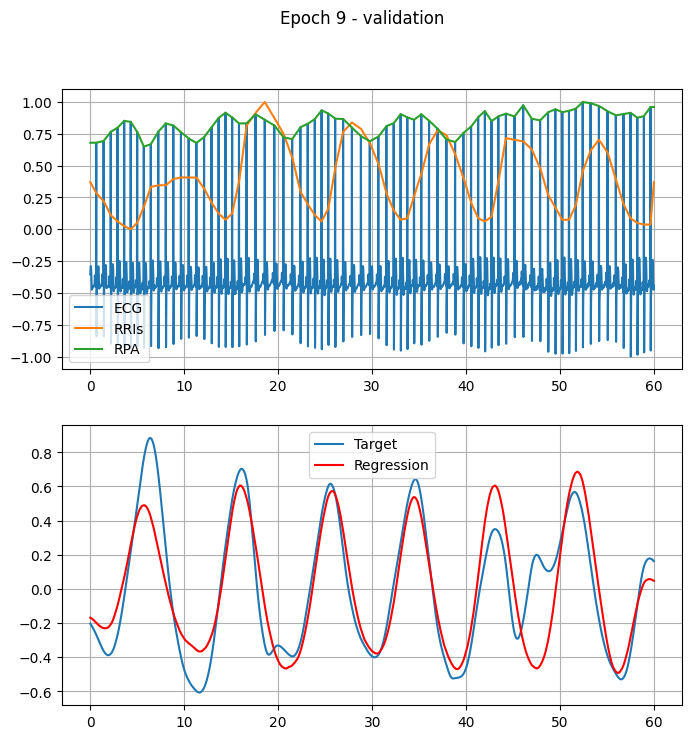

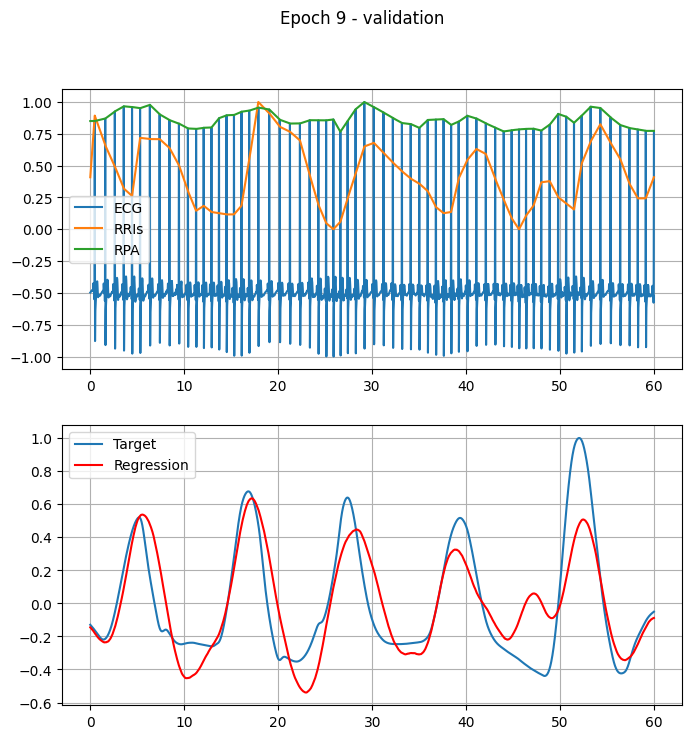

Epoch [9/30], LR: [0.001], Average Train Loss: 0.1376568296033403, Average Validation Loss: 0.5085213532050451


 96%|█████████▌| 22/23 [01:25<00:03,  3.80s/it]

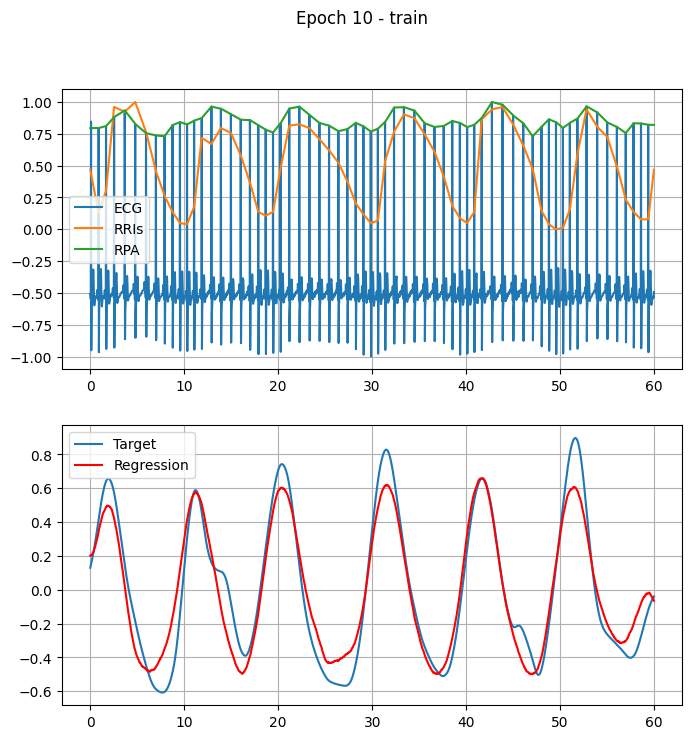

100%|██████████| 23/23 [01:27<00:00,  3.80s/it]


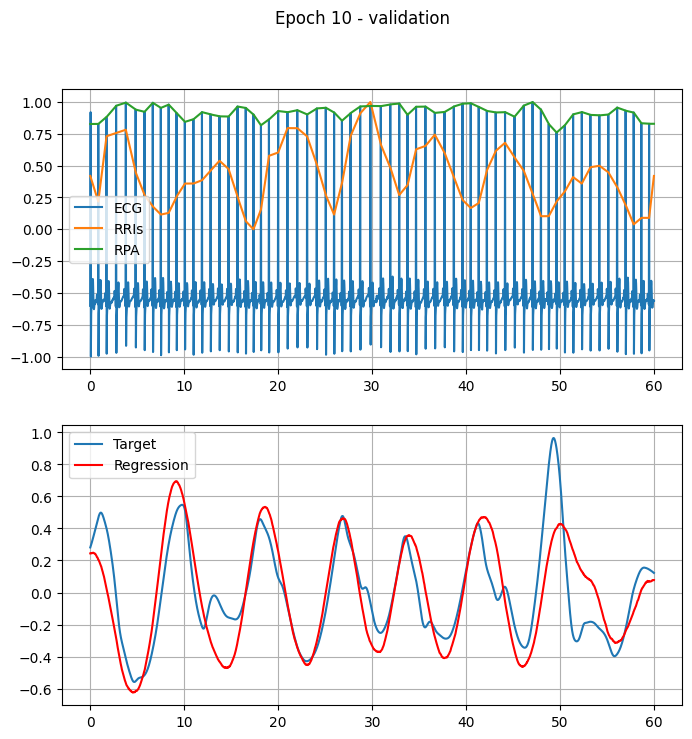

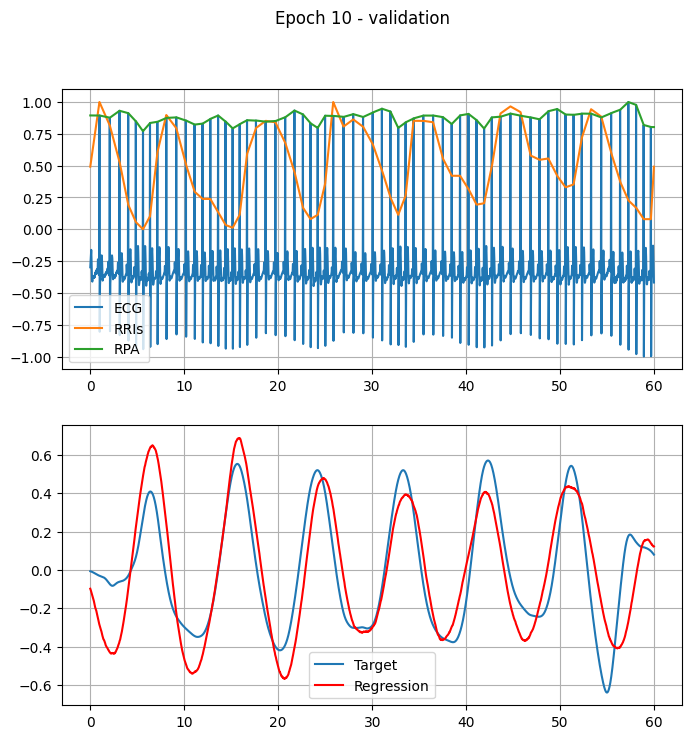

Epoch [10/30], LR: [0.0001], Average Train Loss: 0.12370704373587733, Average Validation Loss: 0.5045212556918462


 96%|█████████▌| 22/23 [01:23<00:03,  3.77s/it]

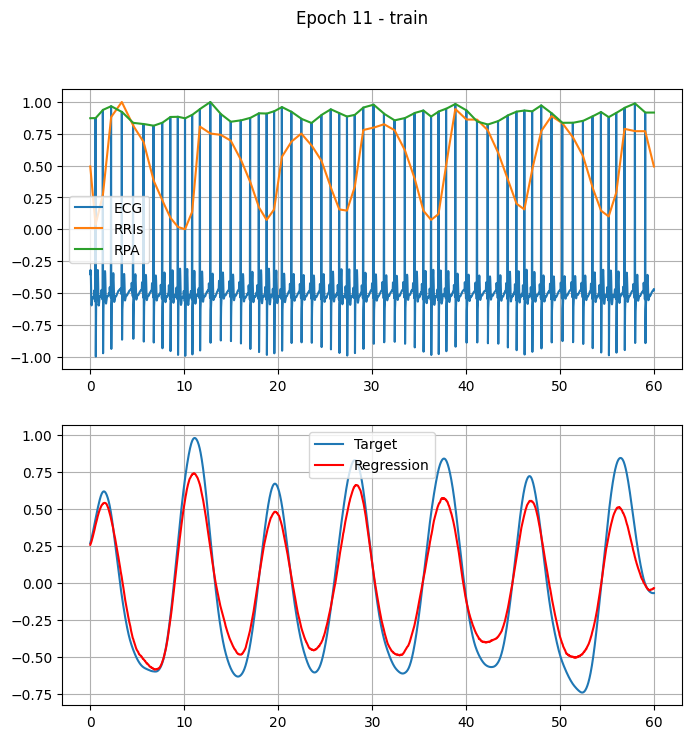

100%|██████████| 23/23 [01:25<00:00,  3.70s/it]


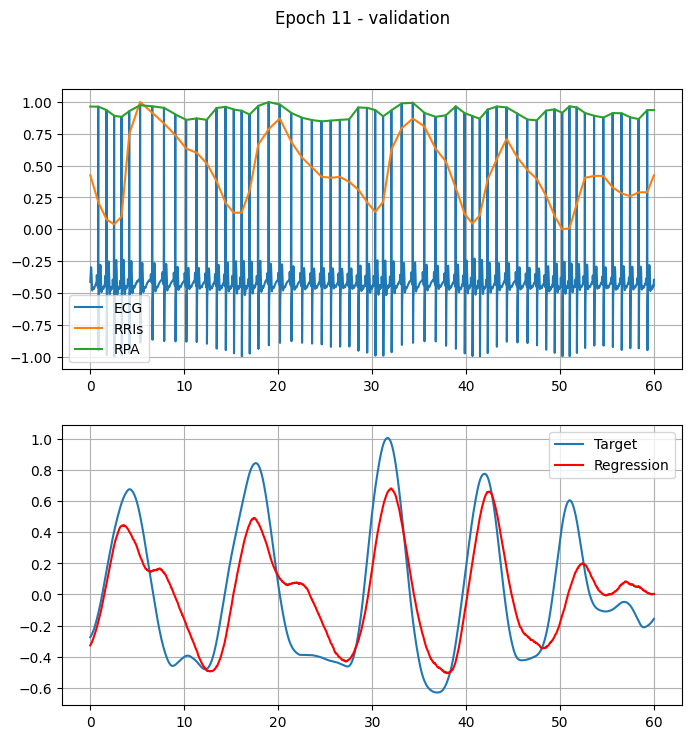

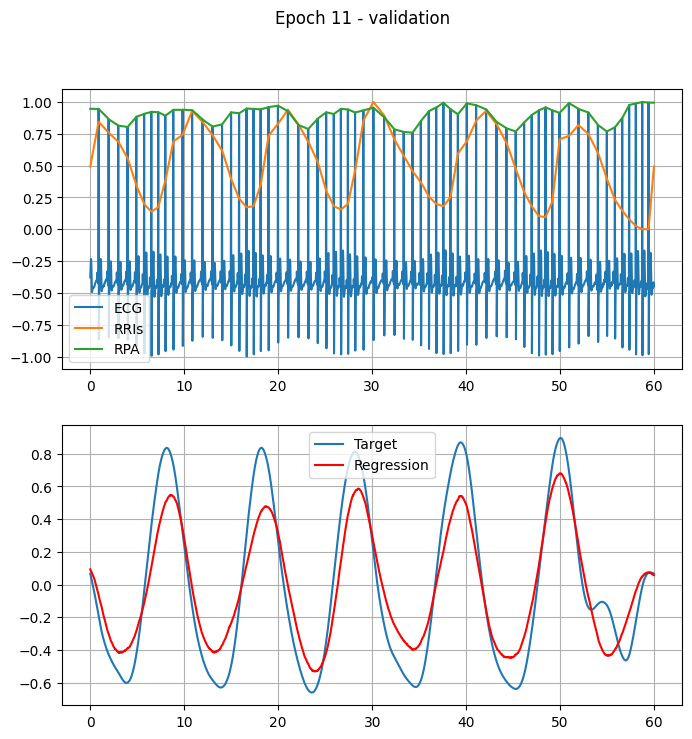

Epoch [11/30], LR: [0.0001], Average Train Loss: 0.09678965742173402, Average Validation Loss: 0.5042753567298254


 96%|█████████▌| 22/23 [01:23<00:03,  3.80s/it]

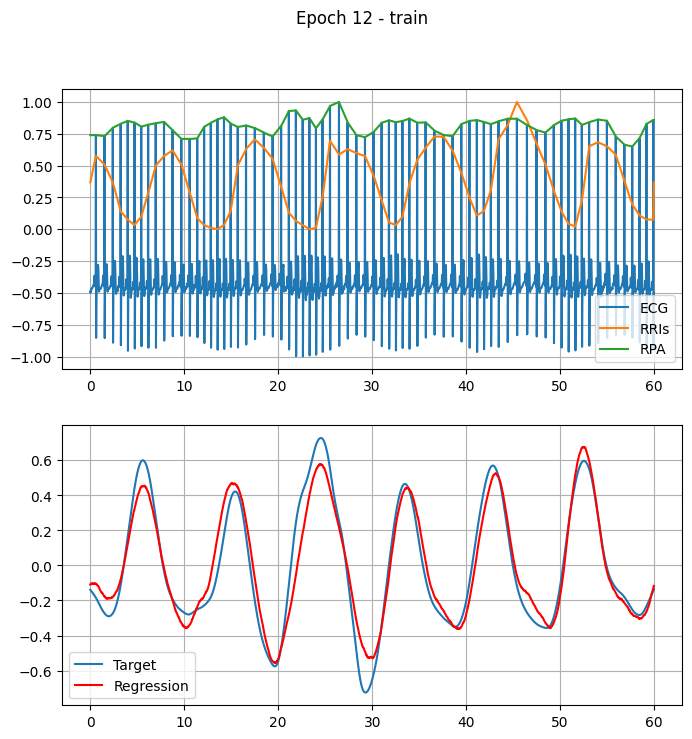

100%|██████████| 23/23 [01:25<00:00,  3.70s/it]


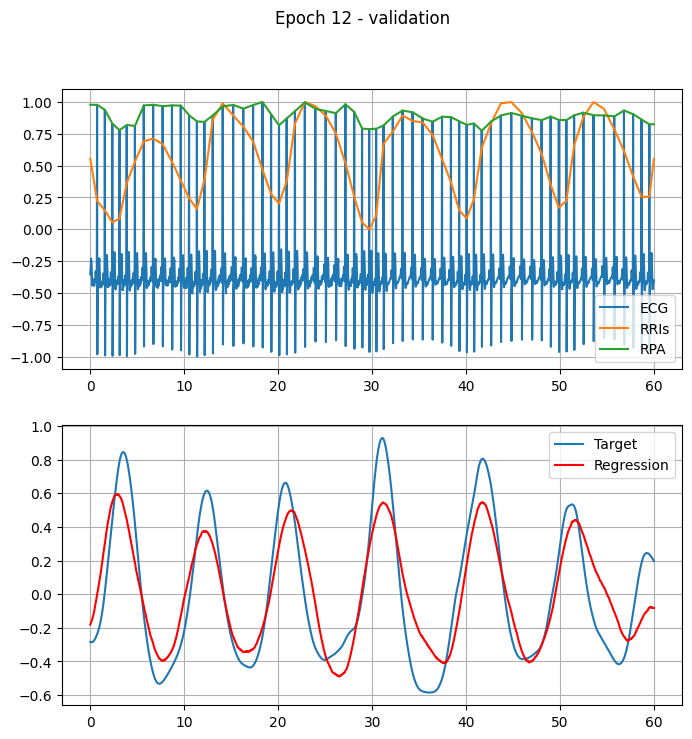

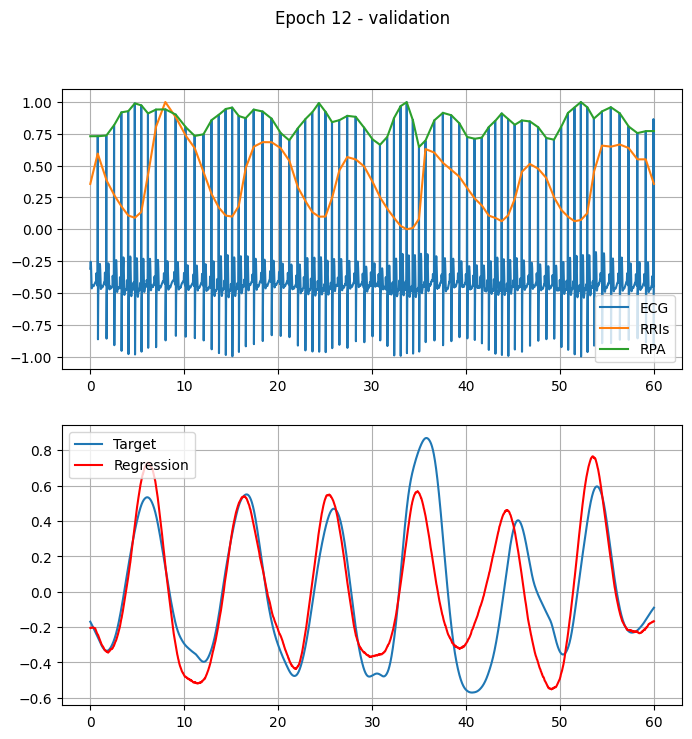

Epoch [12/30], LR: [0.0001], Average Train Loss: 0.08961378199898679, Average Validation Loss: 0.5032267620166143


 78%|███████▊  | 18/23 [01:17<00:21,  4.30s/it]


KeyboardInterrupt: 

In [84]:
model = train(model, train_loader, test_loader, learning_rate=0.001, epochs=30, alfa=0.5)

In [142]:
torch.save(model.state_dict(), "./regession_model.pt")

In [143]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    epoch_val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, (inputs, targets) in enumerate(test_loader):
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()


            if i % 2 == 0:
                RRs = inputs[-1][:,1].detach().cpu().numpy()
                target = targets[-1].detach().cpu().numpy()
                pred = outputs[-1].detach().cpu().numpy()

                plt.figure()
                plt.plot(RRs)
                plt.grid()
                plt.title(f"Resp: {target}, Pred: {pred}")
                plt.show()

    # Return the average validation loss
    return epoch_val_loss / len(test_loader)

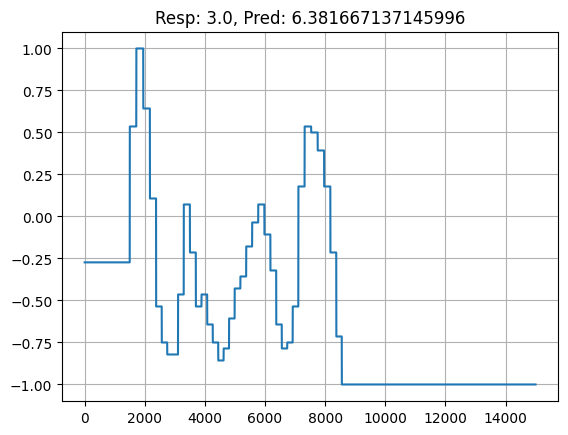

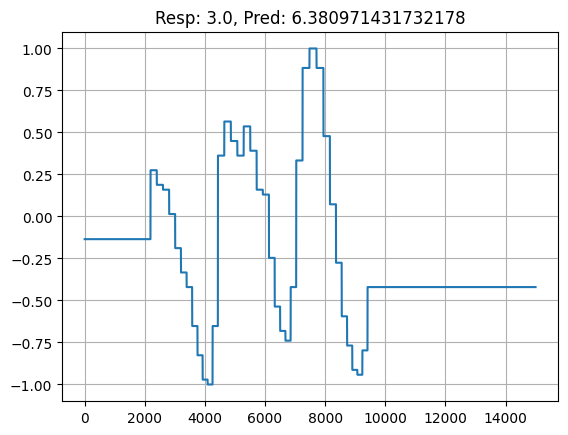

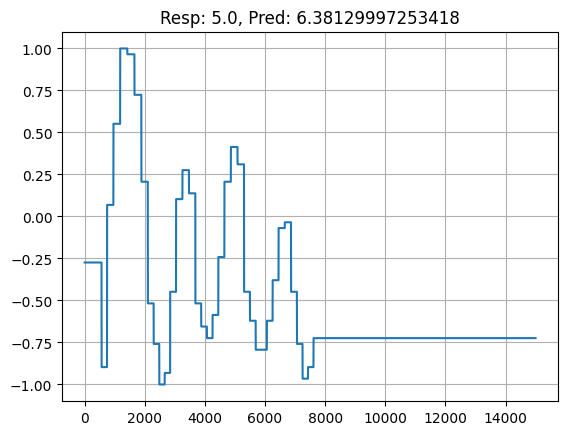

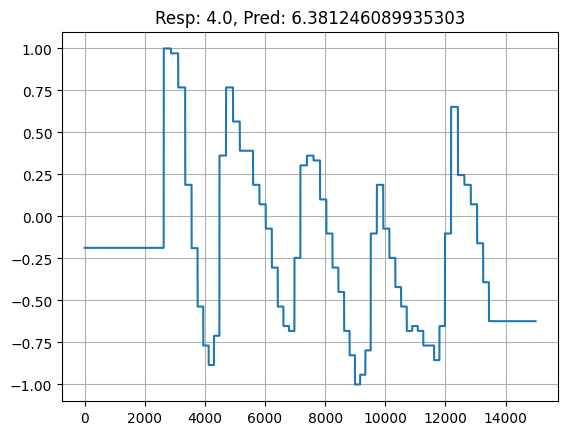

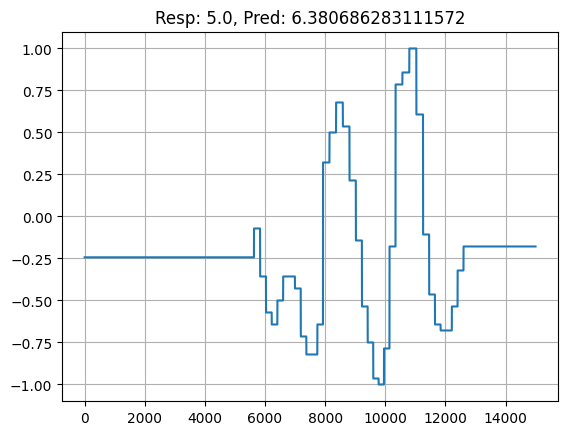

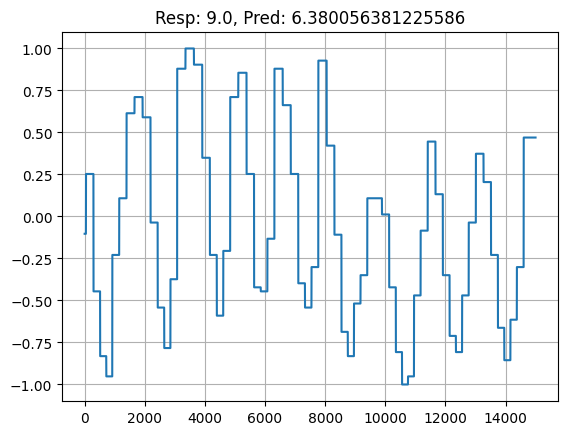

KeyboardInterrupt: 

In [144]:
test(model, test_loader)